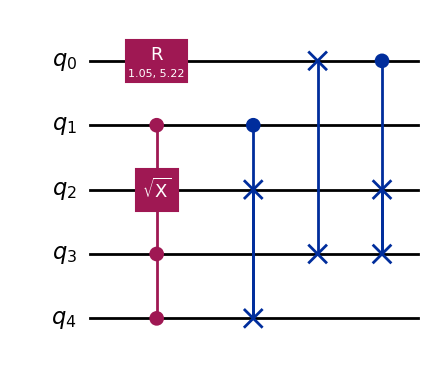

In [34]:
from qiskit.circuit.random import random_circuit
from numpy.random import default_rng

rng = default_rng()

qc = random_circuit(5, 3, measure=False, seed=rng)
qc.draw("mpl", style="iqp")

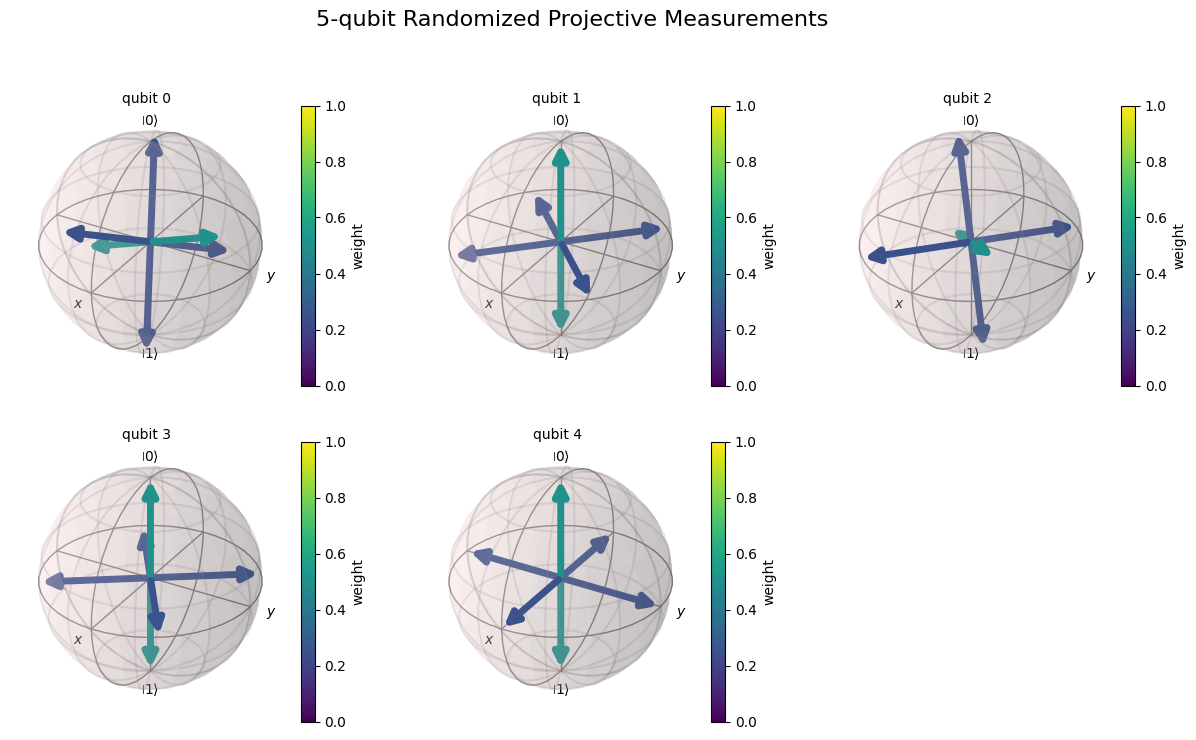

In [35]:
import numpy as np
from povm_toolbox.library import RandomizedProjectiveMeasurements

num_qubits = qc.num_qubits

bias = np.array([0.5, 0.25, 0.25])
angles = np.array(
    [
        [2.01757238, -1.85001671, 2.52155716, 0.45636669, 1.17175533, -0.48263278],
        [0.0, 0.0, 1.57079633, -2.35619449, 1.57079633, -0.78539816],
        [1.94493547, -2.39620342, 0.3760775, -2.28966468, 1.53443501, 2.33046898],
        [0.0, 0.0, 1.57079633, 0.6, 1.57079633, 2.17079633],
        [0.0, 0.0, 1.57079633, 0.0, 1.57079633, 1.57079633],
    ]
)

measurement = RandomizedProjectiveMeasurements(num_qubits, bias=bias, angles=angles, seed=rng)
measurement.definition().draw_bloch(
    title=f"{num_qubits}-qubit Randomized Projective Measurements", colorbar=True
)

In [36]:
from povm_toolbox.sampler import POVMSampler
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler(seed=rng)
povm_sampler = POVMSampler(sampler=sampler)

job = povm_sampler.run([qc], shots=10000, povm=measurement)
pub_result = job.result()[0]

In [37]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(
    ["XIIII", "IIYII", num_qubits * "Y", num_qubits * "Z"], coeffs=[0.5, 0.5, 0.5**num_qubits, 0.5**num_qubits]
)

In [38]:
from povm_toolbox.post_processor import POVMPostProcessor
from qiskit.quantum_info import Statevector

exact_expectation_value = np.real_if_close(Statevector(qc).expectation_value(observable))
print(f"Exact value:     {exact_expectation_value}")

post_processor = POVMPostProcessor(pub_result)

exp_value_canonical, std_canonical = post_processor.get_expectation_value(observable)
print(f"Estimated value: {exp_value_canonical}")
print(f"\nEstimated standard deviation of the estimator: {std_canonical}")

Exact value:     0.015520389138148582
Estimated value: 0.027083948782982245

Estimated standard deviation of the estimator: 0.024499271383453834


In [39]:
from povm_toolbox.post_processor import dual_from_marginal_probabilities

post_processor.dual = dual_from_marginal_probabilities(
    povm=post_processor.povm, state=Statevector(qc)
)

exp_value_marginal, std_marginal = post_processor.get_expectation_value(observable)
print(f"Estimated value: {exp_value_marginal}")
print(f"\nEstimated standard deviation of the estimator: {std_marginal}")

Estimated value: 0.03529355963150229

Estimated standard deviation of the estimator: 0.022536508607252995


In [40]:
from povm_toolbox.post_processor import dual_from_empirical_frequencies

post_processor.dual = dual_from_empirical_frequencies(povm_post_processor=post_processor)

exp_value_freq, std_freq = post_processor.get_expectation_value(observable)
print(f"Estimated value: {exp_value_freq}")
print(f"\nEstimated standard deviation of the estimator: {std_freq}")

Estimated value: 0.03385505492984609

Estimated standard deviation of the estimator: 0.022460467698142514


In [41]:
print(f"Exact value: {exact_expectation_value}\n")

print("Dual frame              Estimated value   Estimated std   Actual error")
print("------------------------------------------------------------------------")
print(
    f"canonical estimators {exp_value_canonical:>18.6f} {std_canonical:>15.6f} {abs(exp_value_canonical - exact_expectation_value):>14.6f}"
)
print(
    f"marginal probabilities {exp_value_marginal:>16.6f} {std_marginal:>15.6f} {abs(exp_value_marginal - exact_expectation_value):>14.6f}"
)
print(
    f"empirical frequencies {exp_value_freq:>17.6f} {std_freq:>15.6f} {abs(exp_value_freq - exact_expectation_value):>14.6f}"
)

Exact value: 0.015520389138148582

Dual frame              Estimated value   Estimated std   Actual error
------------------------------------------------------------------------
canonical estimators           0.027084        0.024499       0.011564
marginal probabilities         0.035294        0.022537       0.019773
empirical frequencies          0.033855        0.022460       0.018335


In [42]:
0.5**2

0.25